# Pipelines

When we begin a data analysis, we want to create a standard methodlogical pipeline.
The pipeline has the following stages:
1. Data collection
2. Data processing
3. Fitting models
4. Testing the quality of the fit.
5. Drawing conclusions from the fit.

If we pack together all of these steps into a single pipeline, then we ensure the reproducibility of our results.
Below, I have a number of examples. Some of them are based on the standard /Pipeline/ offered by sklearn.


## 1. Data collection

Here the data is loaded and the most basic operations are performed. In this case, we can remove some columns that we /a priori/ know are useless. In a simulation setting, however, data collection is going to be done by sampling from a distribution.


In [1]:
import pandas as pd
data = pd.read_csv("Intro to ML Class.csv")
data = data.drop(['Pseudonym'], axis=1)
data

,Height,Weight,Gender,Age,Sporthours/week,"Location: (0 Village, 1: Town, 2: City, 3: Megacity)"
0,178.00,81,M,49,7,1
1,180.00,75,M,22,16,1
2,169.00,53,F,20,0,2
3,183.00,80,M,25,1,1
4,190.00,65,M,25,5,0
5,178.00,82,M,21,4,0
6,188.00,85,M,25,8,1
7,178.00,65,M,24,2,1
8,179.00,69,M,23,2,0
9,178.00,60,M,37,0,1


## Step 2 and 3. Data preprocessing and fitting

sklearn allows us to create a single pipeline for all the preprocessing we want to do. This is very useful if we already know what kind of processing we want to do.

In [2]:
# set up the pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
classification_pipeline = Pipeline([('scaler', StandardScaler()), ('perceptron', Perceptron())])


In [8]:
# fit data
X = data.copy().drop(['Gender'], axis=1)
y = data['Gender']
classification_pipeline.fit(X, y)
classification_pipeline.predict(X)

array(['M', 'M', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'F', 'M',
       'F', 'M', 'M', 'F', 'M', 'F'], dtype='<U1')

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer


In [11]:
numeric_features = [ "Height", "Age", "Sporthours/week"]
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = ["Gender"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder())
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [239]:
data = pd.read_csv("Intro to ML Class.csv")
data = data.drop(['Pseudonym'], axis=1)
X = data.copy().drop(["Weight"], axis=1)
y = data["Weight"].copy()

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)
clf.fit(X, y)
print(clf.predict(X) - y) # show the prediction error


0     -2.883452
1      3.226370
2      7.131108
3    -11.572562
4      6.869569
5    -12.791833
6    -11.140065
7      3.496266
8     -0.663432
9     10.196834
10    -2.523317
11     3.808253
12     6.847272
13     1.088980
14     1.203570
15   -10.668890
16     0.521074
17     9.213707
18    -1.359452
Name: Weight, dtype: float64


# From simple pipelines to simulation


In [24]:
np.random.choice(['A', 'B'])

'B'

In [298]:
import numpy as np
# We can make a number of different simulations, one for each case
def SimpleClassDataGenerator(n_samples, m_height=175, f_height=165, m_weight=0.4, f_weight=0.3):
    features = ["Height", "Weight", "Gender", "Age", "Sporthours/week", "Location"]
    n_features = len(features)
    X = np.zeros([n_samples, n_features])
    df = pd.DataFrame(X, columns=features)
    for t in range(n_samples):
        # Assume no relation between gender, age, location and sports
        # However this assumption might be false
        df.at[t, 'Gender']= np.random.choice(2)
        age = 18+np.random.negative_binomial(5,0.3)
        df.at[t, 'Age']= age
        df.at[t, 'Location']= np.random.choice([0,1,2,3], p=[0.2, 0.3, 0.45, 0.05])
        df.at[t, 'Sporthours/week'] = np.random.negative_binomial(4,0.5)
        sport_weight =  age / (age  + df.at[t, 'Sporthours/week']) # older people lose weight less effectively?
        if (df.at[t,'Gender']== 1):            
            df.at[t,'Height'] = np.random.gamma(m_height,1)
            df.at[t,'Weight'] = (df.at[t, 'Height'] + np.random.gamma(20,1))*m_weight*sport_weight
            
        else:
            df.at[t,'Height'] = np.random.gamma(f_height,1)
            df.at[t,'Weight'] = (df.at[t, 'Height'] + np.random.gamma(20,1))*f_weight*sport_weight
    return df
    

In [299]:
def my_pipeline(data):
    # get data
    X = data.copy().drop(["Weight"], axis=1)
    y = data["Weight"].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    # construct data processing pipeline
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = np.mean((y_pred - y_test)**2)
    return mse, clf.coef_

# Experiment design

We can perform multiple experiments to take into account the variability of the data.
We can start by seing see how well we can predict the weight from measurements with different amounts of data.
By altering the simulator parameters, we can see how well our model is able to capture the dependencies between different variables. This can inform our experiment design:
- How much data do we need to collect?
- When can we expect to have a reasonable result?

In [290]:
data_sizes = [10,20,50,100,200,500,1000,2000,5000,10000]
n_experiments=10
mse = np.zeros([n_experiments, len(data_sizes)])
c_height = np.zeros([n_experiments, len(data_sizes)])
c_gender = np.zeros([n_experiments, len(data_sizes)])

for t in range(n_experiments):
    k = 0
    for n_data in data_sizes:
        mse[t, k], coeffs   = my_pipeline(SimpleClassDataGenerator(n_data))
        c_height[t, k] = coeffs[0]
        c_gender[t, k] = coeffs[1]
        k+=1



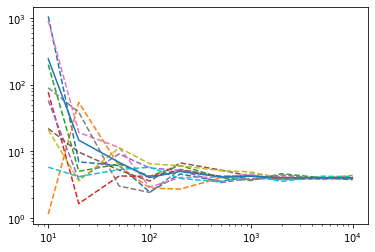

In [291]:
# As we can see from this plot, we need at least 100 measurements 
plt.loglog(data_sizes, mse.transpose(), '--')
plt.loglog(data_sizes, np.mean(mse, axis=0))

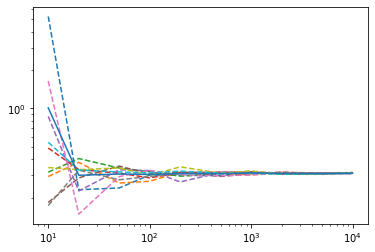

In [295]:
# As we can see from this plot, we need at least 100 measurements 
plt.loglog(data_sizes, c_height.transpose(), '--')
plt.loglog(data_sizes, np.mean(c_height, axis=0))

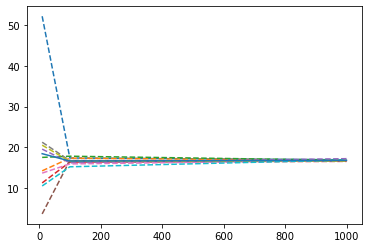

In [288]:
# As we can see from this plot, we need at least 100 measurements 
plt.plot(data_sizes, c_gender.transpose(), '--')
plt.plot(data_sizes, np.mean(c_gender, axis=0))


Let's now repeat the experiment for classification...
